# Tree-Based Methods

In [7]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
import numpy as np
from sklearn.impute import SimpleImputer
from numpy import mean, std 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import weka.core.jvm as jvm
import weka.core.converters as convert
import weka.core.converters as converters
from weka.classifiers import Classifier
from weka.classifiers import Evaluation
from weka.core.classes import Random
import weka.plot.classifiers as plcls 
from imblearn.over_sampling import SMOTE

##  Data Preparation

### read data

In [8]:
df_train = pd.read_csv("aps_failure_training_set.csv", skiprows = 20)
df_test = pd.read_csv("aps_failure_test_set.csv", skiprows = 20)

### deal with missing value

In [9]:
df_train=df_train.replace({"na" : np.nan, "neg": 0, "pos" : 1})
df_test=df_test.replace({"na" : np.nan,  "neg": 0, "pos" : 1})

# SimpleImputer deal with missing value use mean
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

df_train_col = df_train.columns
df_test_col = df_test.columns

df_train = imp.fit_transform(df_train)
df_test = imp.fit_transform(df_test)

df_train = pd.DataFrame(df_train, columns = df_train_col)
df_test = pd.DataFrame(df_test, columns = df_test_col)

### calculate the CV for each fatures

In [10]:
CV=std(df_train.iloc[:,1:])/mean(df_train.iloc[:,1:])  #It reflects the dispersion degree of the observed values of each index on the unit mean
CV

aa_000      2.450917
ab_000      2.328381
ac_000      2.169748
ad_000    183.846088
ae_000     23.190743
             ...    
ee_007      4.962441
ee_008      3.221983
ee_009      5.626932
ef_000     47.124560
eg_000     40.552912
Length: 170, dtype: float64

### plot correlation matrix 

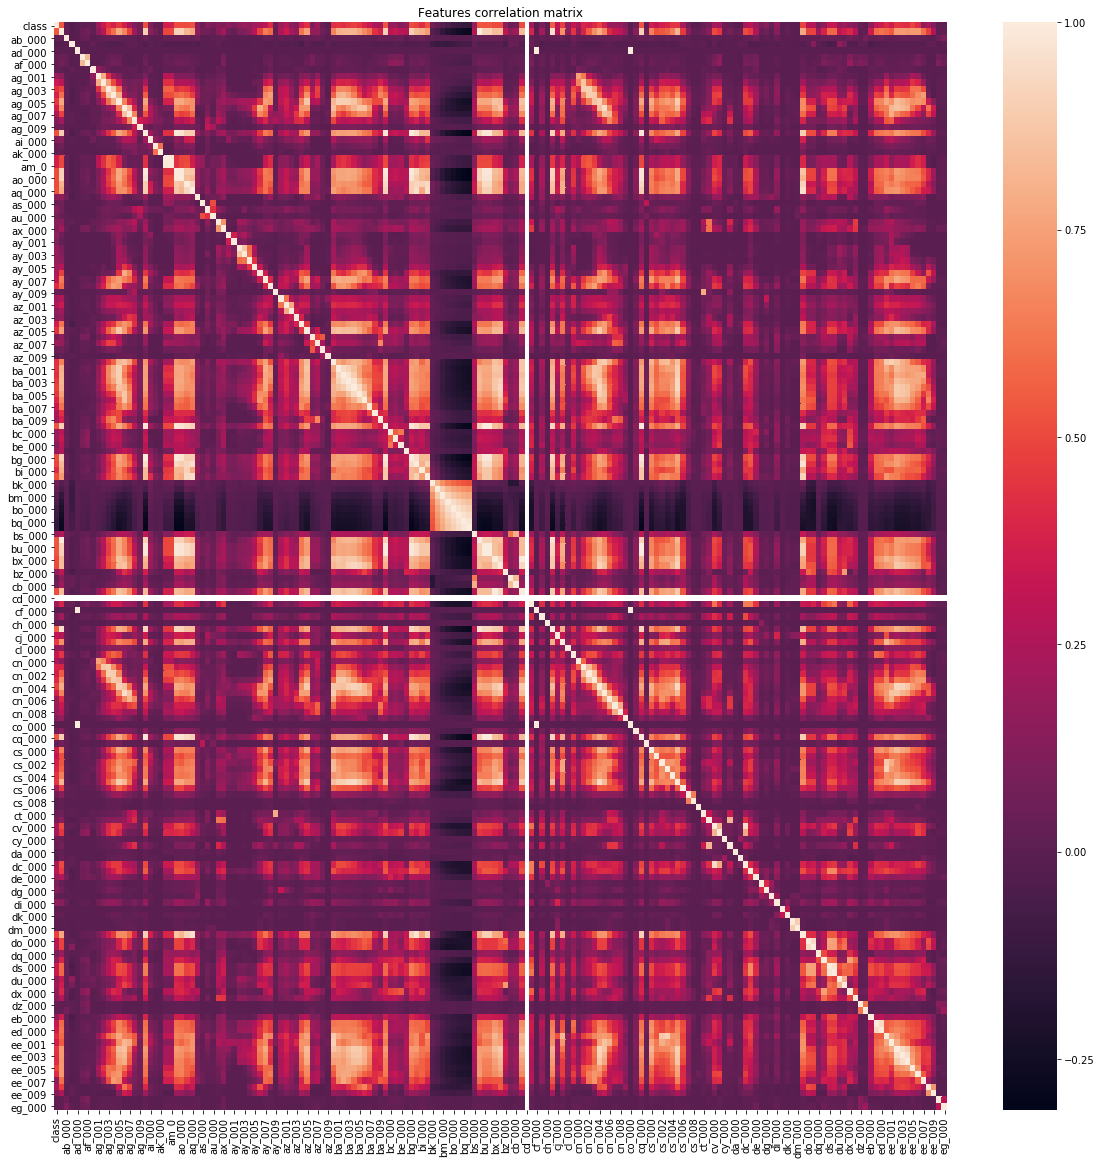

In [11]:
correlation = df_train.corr()
fig, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(correlation)
ax.set_title('Features correlation matrix')
plt.show()

### Pick 170**0.5 features with highest CV , and make scatter plots and box plots 

In [6]:
highest_CV=CV.sort_values(ascending = False)[:round(170**0.5)]
highest_CV

cs_009    235.275644
cf_000    184.231557
co_000    183.947485
ad_000    183.846088
dh_000    114.984033
dj_000    109.646371
ag_000     91.877799
as_000     86.416184
ay_009     83.785365
az_009     76.967337
ak_000     74.526067
au_000     68.159986
ch_000     58.267743
dtype: float64

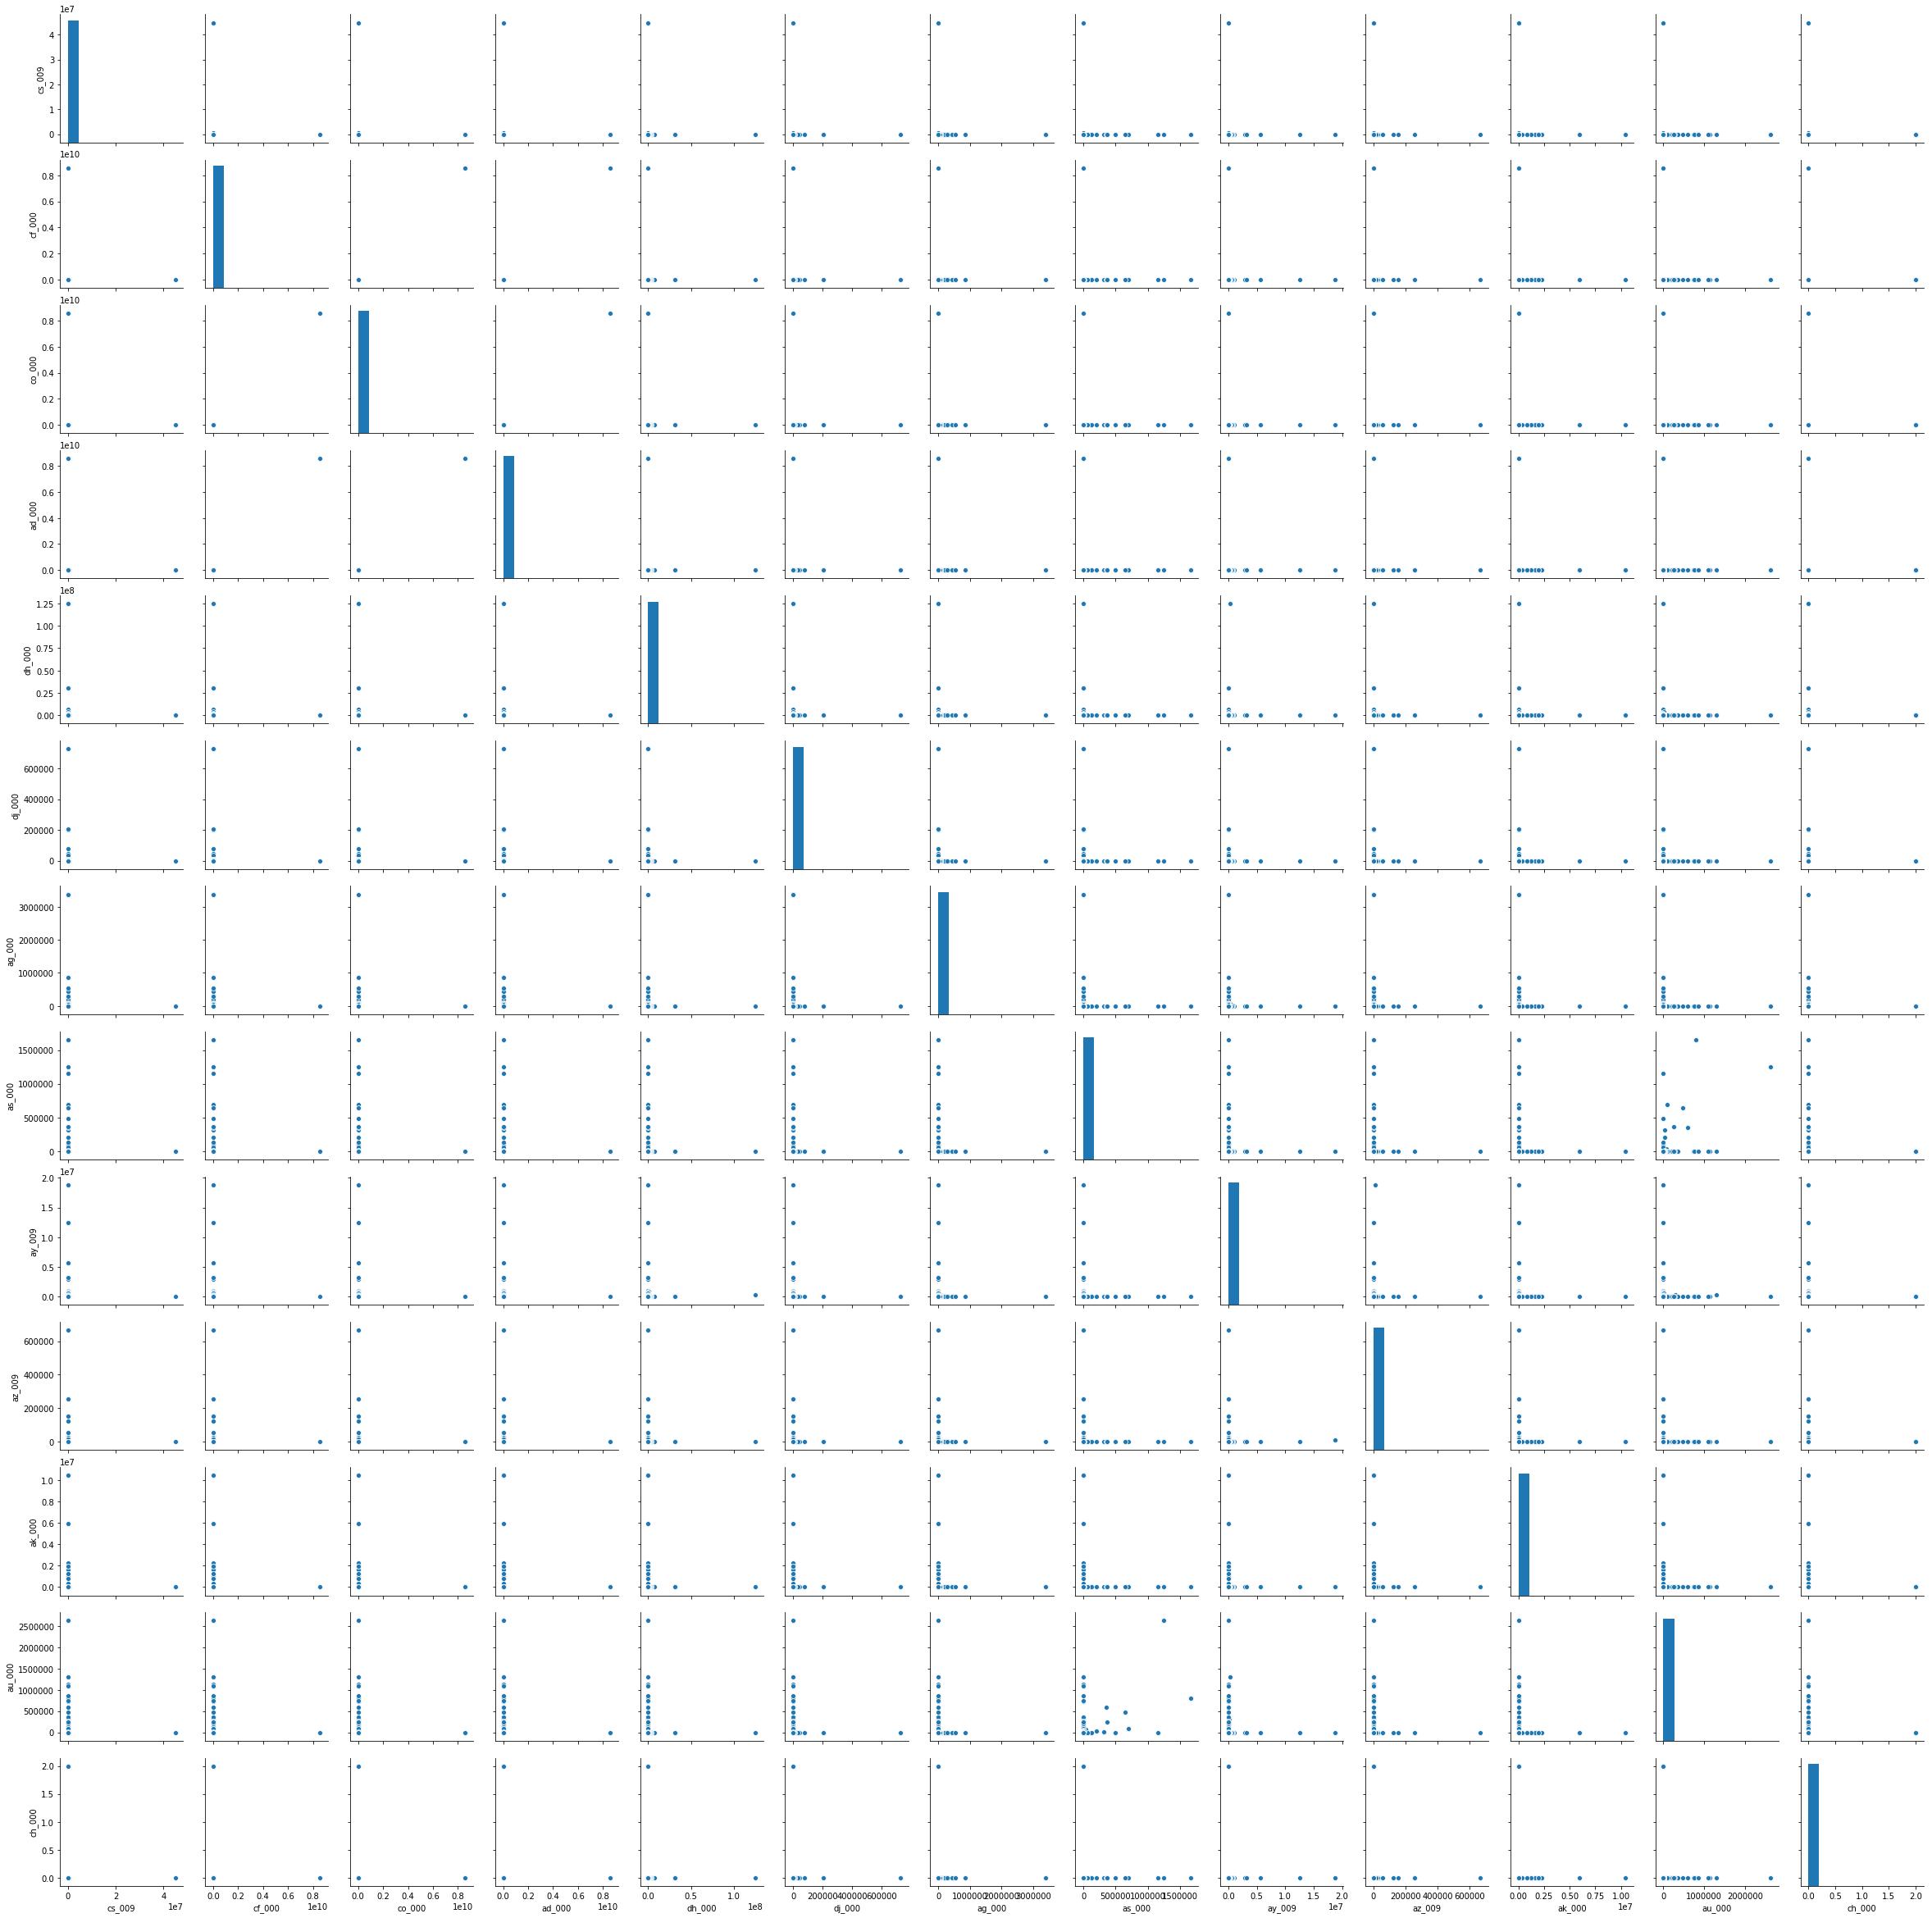

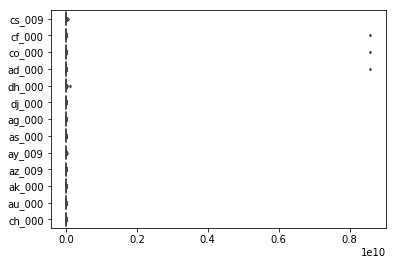

In [7]:
# scatter plots
feature=highest_CV.index.tolist()
new_training=df_train[feature]
sns.pairplot(new_training)
plt.show()

# box plots
sns.boxplot(data=new_training,orient="h",fliersize=2) 
plt.show()

<font color=black size=4 face=雅黑>Answer: From the scatter plot we can see that there is no relationship between these features </font>

### the number of positive and negative data

In [8]:
number_train=df_train["class"].value_counts()
print("the number of training's positive and negative:\n",number_train)

number_test=df_test["class"].value_counts()
print("the number of test's positive and negative:\n",number_train)

the number of training's positive and negative:
 0.0    59000
1.0     1000
Name: class, dtype: int64
the number of test's positive and negative:
 0.0    59000
1.0     1000
Name: class, dtype: int64


<font color=black size=4 face=雅黑>Answer: the data set is imbalance </font>

## Fit model

### Random forest to classify data set, calcuate confusion matrix, ROC, AUC and Out of Bag error

In [9]:
# split data to label and features
x_train = df_train.iloc[:,1:]
x_test = df_test.iloc[:,1:]
y_train = df_train.iloc[:,0]
y_test = df_test.iloc[:,0]

test error: 0.009312499999999946
oob test error: 0.009299999999999975
AUC: 0.8286613333333331


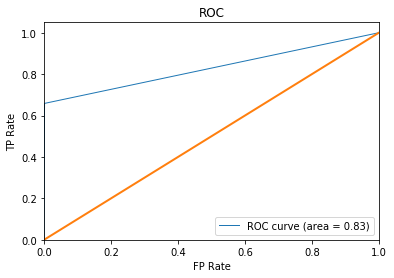

confusion matrix:
 [[15604    21]
 [  128   247]]


In [10]:
pd.set_option('display.max_columns', None)
# use random forest to classify the data set
clf = RandomForestClassifier(oob_score = True)
model=clf.fit(x_train,y_train)
y_predict=model.predict(x_test)

test_error =1-model.score(x_test,y_test)
print('test error:',test_error)
oob_test_error = 1 - model.oob_score_
print('oob test error:',oob_test_error)

# ROC curve plot
lw=2
fpr, tpr, thresholds = roc_curve(y_test, y_predict)
roc_auc = auc(fpr, tpr)
print('AUC:',roc_auc)

plt.figure()
plt.plot(fpr, tpr, lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

# confusion matrix
cm=confusion_matrix(y_test, y_predict)
print('confusion matrix:\n',cm)

<font color=black size=4 face=雅黑>Answer: Compare the two error we can find the Out of Bag error is smaller than test error </font>

### Deal with class imbalance in random forest

test error: 0.008812500000000001
oob test error: 0.008449999999999958
AUC: 0.8367253333333333


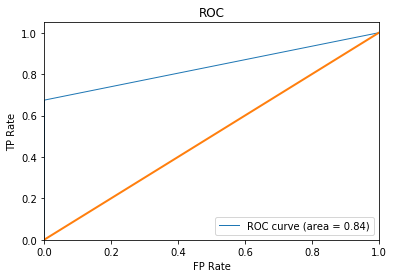

confusion matrix:
 [[15606    19]
 [  122   253]]


In [11]:

# deal with imbalance clss
ros = RandomOverSampler(random_state=0)
x_resampled, y_resampled = ros.fit_sample(x_train, y_train)

# use random forest to classify the data set
clf = RandomForestClassifier(oob_score = True)
model=clf.fit(x_train,y_train)
y_predict=model.predict(x_test)

test_error =1-model.score(x_test,y_test)
print('test error:',test_error)
oob_test_error = 1 - model.oob_score_
print('oob test error:',oob_test_error)

# ROC curve plot
lw=2
fpr, tpr, thresholds = roc_curve(y_test, y_predict)
roc_auc = auc(fpr, tpr)
print('AUC:',roc_auc)

plt.figure()
plt.plot(fpr, tpr, lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

# confusion matrix
cm=confusion_matrix(y_test, y_predict)
print('confusion matrix:\n',cm)

<font color=black size=4 face=雅黑>Answer: Compare the two error we can find the Out of Bag error is smaller than test error </font>

### Model Trees

In [12]:
jvm.stop()
jvm.start()

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/anaconda3/lib/python3.7/site-packages/javabridge/jars/rhino-1.7R4.jar', '/anaconda3/lib/python3.7/site-packages/javabridge/jars/runnablequeue.jar', '/anaconda3/lib/python3.7/site-packages/javabridge/jars/cpython.jar', '/anaconda3/lib/python3.7/site-packages/weka/lib/python-weka-wrapper.jar', '/anaconda3/lib/python3.7/site-packages/weka/lib/weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support disabled


In [14]:
#read training data from dataframe
df_train["class"]=df_train["class"].apply(lambda x: "neg" if x==0 else "pos")
df_x=df_train.iloc[:,1:]
df_y=df_train["class"]
new_df_train=pd.concat([df_x,df_y],axis=1)
new_df_train.to_csv("training_set.csv",sep=",",index=None) 
aps_train = convert.load_any_file(filename="training_set.csv")
aps_train.class_is_last()

In [15]:
#logistic model tree
logistic_tree=Classifier(classname="weka.classifiers.trees.LMT",options=["-B"])
logistic_tree_evaluation=Evaluation(aps_train)
logistic_tree_evaluation.crossvalidate_model(logistic_tree, aps_train, 5,Random(0))
print('train error:',logistic_tree_evaluation.percent_incorrect)
print('confusion matrix:',logistic_tree_evaluation.matrix())

train error: 0.8216666666666667
confusion matrix: === Confusion Matrix ===

     a     b   <-- classified as
 58813   187 |     a = neg
   306   694 |     b = pos



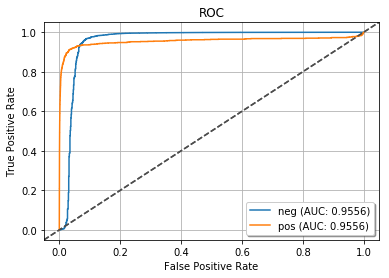

In [16]:
plcls.plot_roc(logistic_tree_evaluation, class_index=[0, 1], wait=True)

In [17]:
#read test data from dataframe
df_test["class"]=df_test["class"].apply(lambda x: "neg" if x==0 else "pos")
df_x=df_test.iloc[:,1:]
df_y=df_test["class"]
new_df_test=pd.concat([df_x,df_y],axis=1)
new_df_test.to_csv("test_set.csv",sep=",",index=None) 
aps_test = convert.load_any_file(filename="test_set.csv")
aps_test.class_is_last()

In [18]:
#logistic model tree
logistic_tree=Classifier(classname="weka.classifiers.trees.LMT",options=["-B"])
logistic_tree_evaluation=Evaluation(aps_test)
logistic_tree_evaluation.crossvalidate_model(logistic_tree, aps_test, 5,Random(0))
print('test error:',logistic_tree_evaluation.percent_incorrect)
print('confusion matrix:',logistic_tree_evaluation.matrix())

test error: 1.125
confusion matrix: === Confusion Matrix ===

     a     b   <-- classified as
 15570    55 |     a = neg
   125   250 |     b = pos



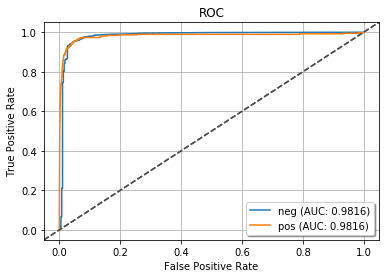

In [19]:
plcls.plot_roc(logistic_tree_evaluation, class_index=[0, 1], wait=True)

### Use Smote to pre-process data to cpmpensate for class imbalance

In [36]:
#read training data from dataframe
smote=SMOTE(random_state=0,ratio=1)
train_smote_fit=smote.fit_sample(df_x,df_y)
x_train_smote=pd.DataFrame(train_smote_fit[0])
y_train_smote=pd.DataFrame(train_smote_fit[1],columns=['class'])
new_smote_train=pd.concat([x_train_smote,y_train_smote],axis=1)

new_smote_train.to_csv("smote_training_set.csv",sep=",",index=None) 
smote_train = convert.load_any_file(filename="smote_training_set.csv")
smote_train.class_is_last()

In [37]:
#logistic model tree
logistic_tree=Classifier(classname="weka.classifiers.trees.LMT",options=["-B"])
logistic_smote_tree_evaluation=Evaluation(smote_train)
logistic_smote_tree_evaluation.crossvalidate_model(logistic_tree, smote_train, 5,Random(0))
print('smote train error:',logistic_smote_tree_evaluation.percent_incorrect)
print('confusion matrix:',logistic_smote_tree_evaluation.matrix())

smote train error: 1.471186440677966
confusion matrix: === Confusion Matrix ===

     a     b   <-- classified as
 57997  1003 |     a = neg
   733 58267 |     b = pos



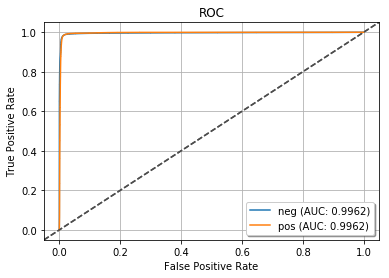

In [39]:
import weka.plot.classifiers as plcls  
plcls.plot_roc(logistic_smote_tree_evaluation, class_index=[0, 1], wait=True)

In [42]:
#read test data from dataframe
smote=SMOTE(random_state=0,ratio=1)
test_smote_fit=smote.fit_sample(df_x,df_y)
x_test_smote=pd.DataFrame(test_smote_fit[0])
y_test_smote=pd.DataFrame(test_smote_fit[1],columns=['class'])
new_smote_test=pd.concat([x_test_smote,y_test_smote],axis=1)

new_smote_test.to_csv("smote_test_set.csv",sep=",",index=None) 
smote_test = convert.load_any_file(filename="smote_test_set.csv")
smote_test.class_is_last()

In [43]:
#logistic model tree
logistic_tree=Classifier(classname="weka.classifiers.trees.LMT",options=["-B"])
logistic_smote_tree_evaluation=Evaluation(smote_test)
logistic_smote_tree_evaluation.crossvalidate_model(logistic_tree, smote_test, 5,Random(0))
print('smote train error:',logistic_smote_tree_evaluation.percent_incorrect)
print('confusion matrix:',logistic_smote_tree_evaluation.matrix())

smote train error: 1.471186440677966
confusion matrix: === Confusion Matrix ===

     a     b   <-- classified as
 57997  1003 |     a = neg
   733 58267 |     b = pos



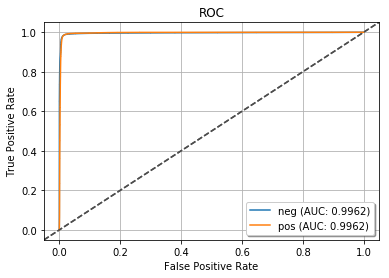

In [44]:
plcls.plot_roc(logistic_smote_tree_evaluation, class_index=[0, 1], wait=True)

<font color=black size=6 face=雅黑>ISLR 6.8.3</font>

<font color=black size=4 face=雅黑>Answer:when s incrase from 0, which means the constrain of coeifficent will decrease, so the model is more flexible, therefore the RSS of training will decrease; the RSS of test will decrease and then increase, like U shape; the variance will increase; the bias will decrease; the irreducible is constant</font>

<font color=black size=6 face=雅黑>ISLR 6.8.5</font>

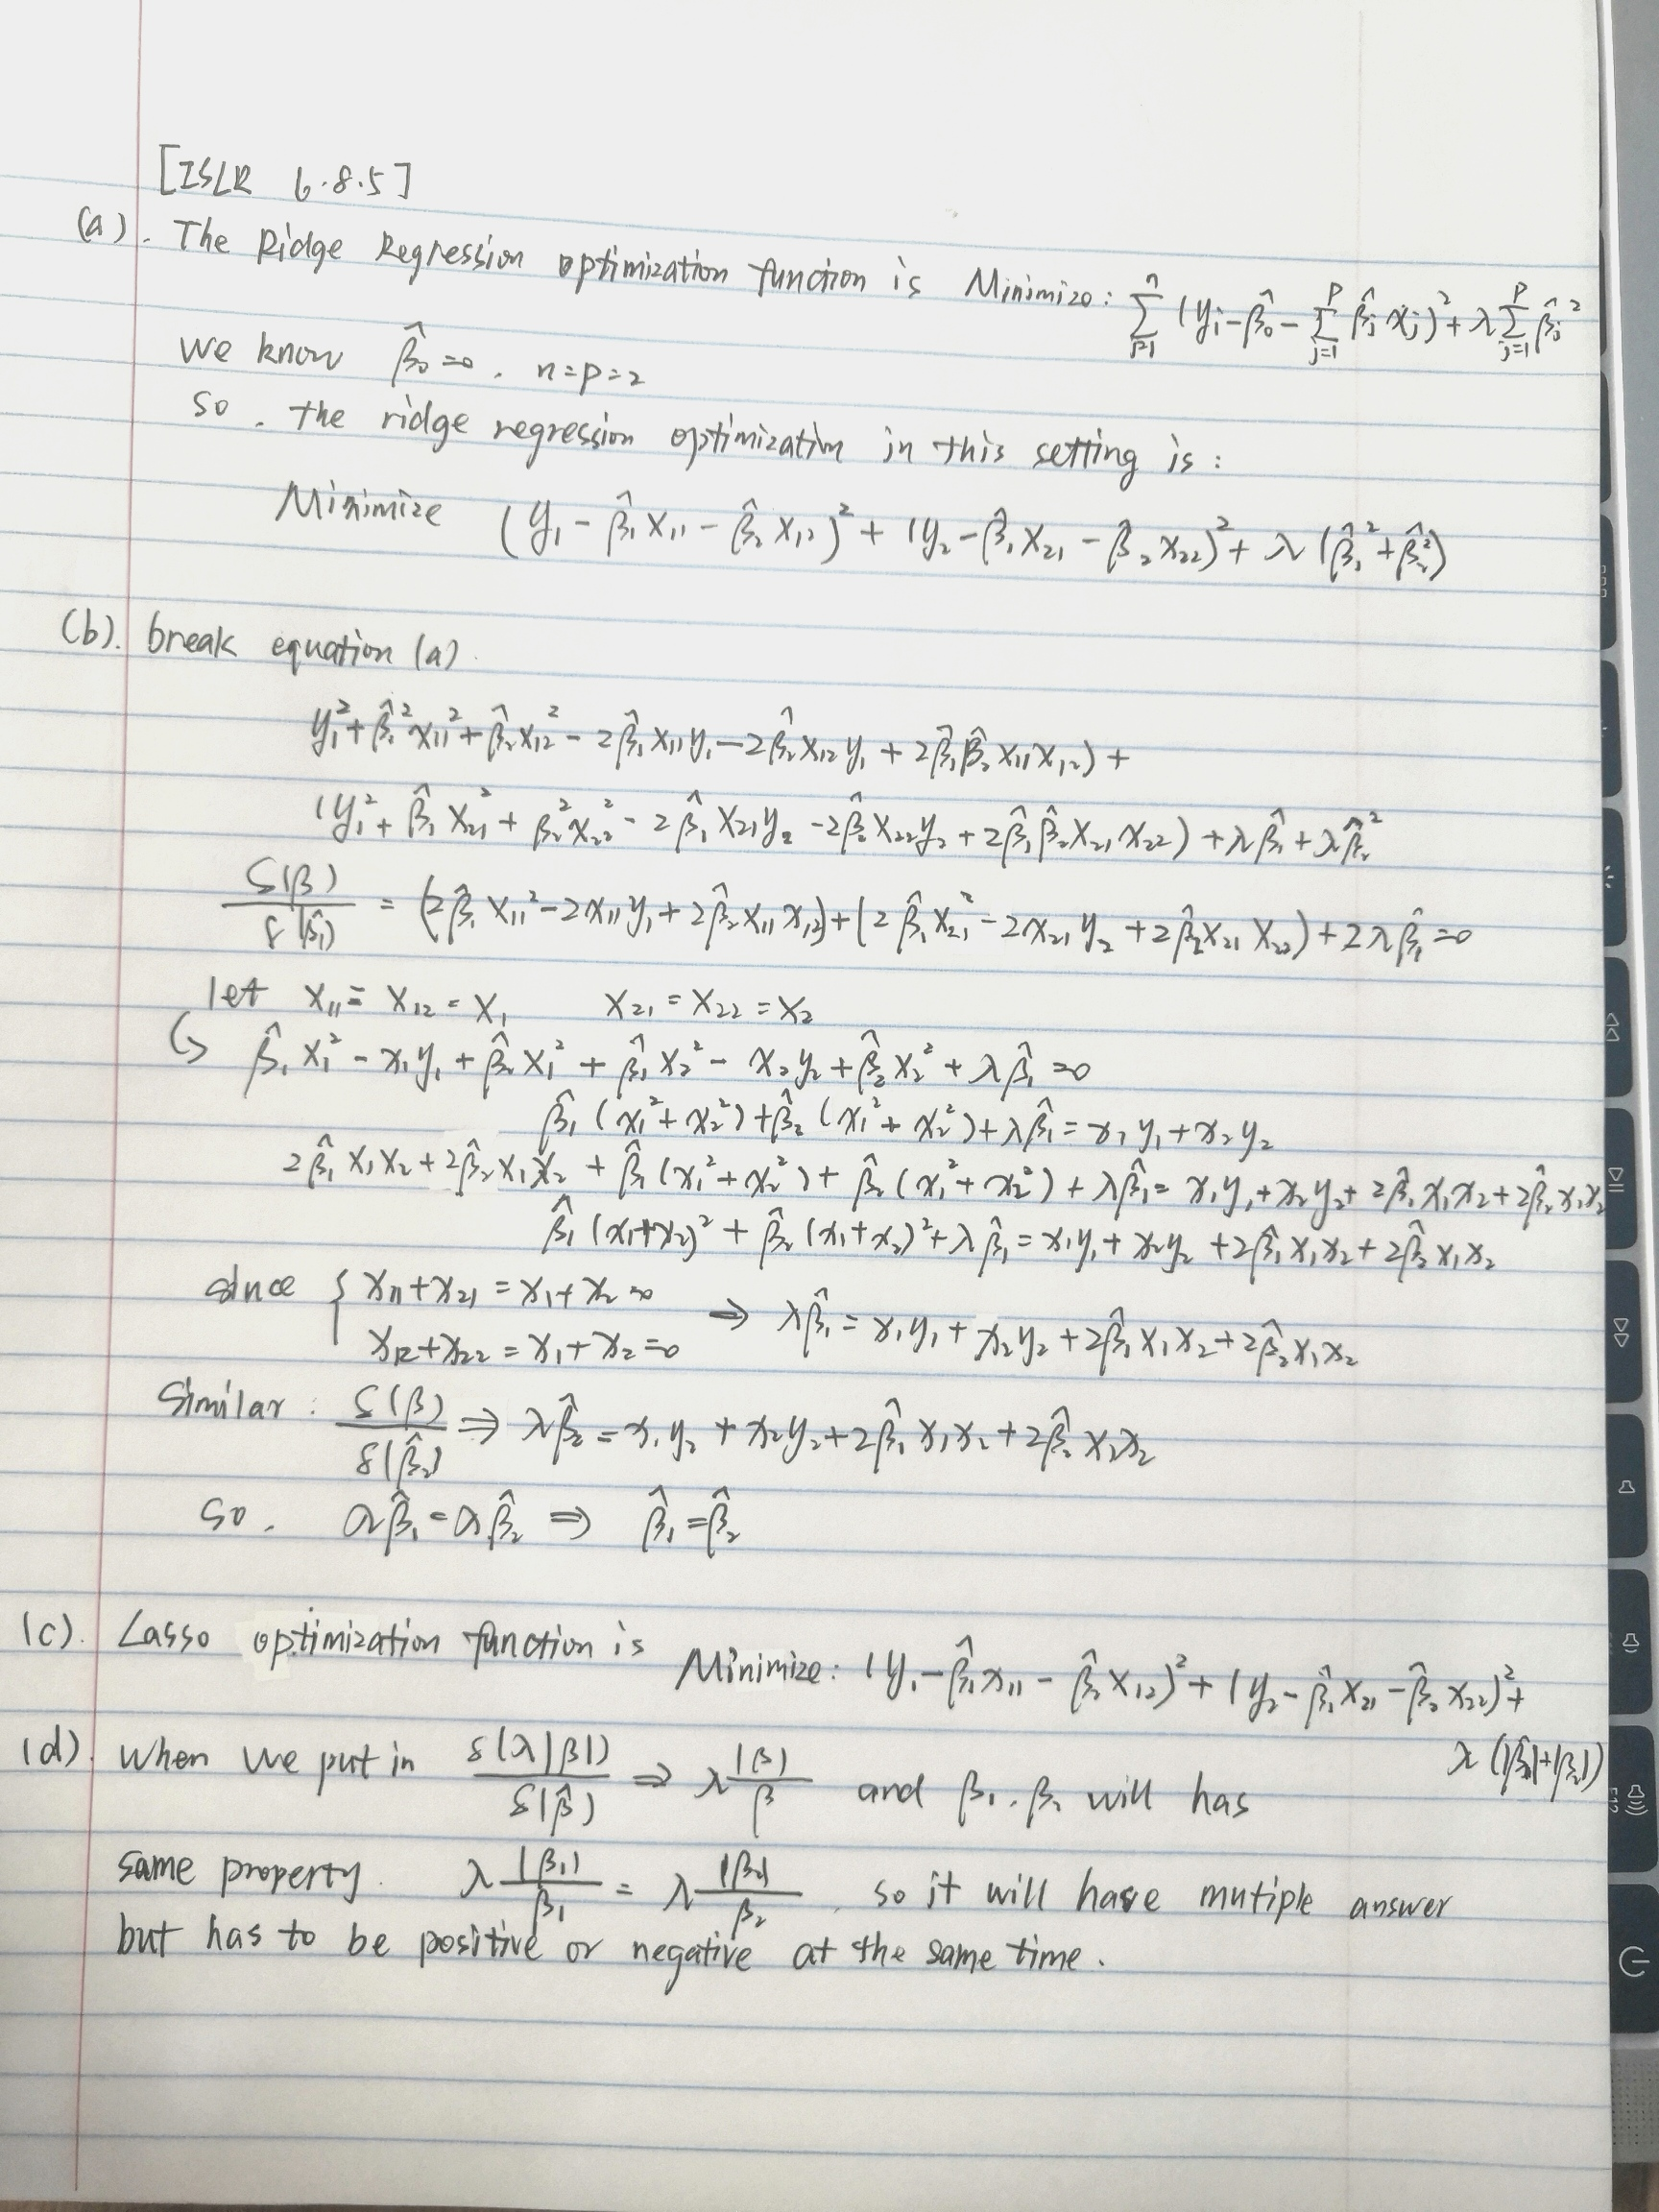

<font color=black size=6 face=雅黑>ISLR 8.4.5</font>

Majority vote method:from the estimates of P, 4 records less than 0.5 and 6 records bigger than 0.5, so we predict the X is red. On the average probability: the average of 10 records is 0.45, so we predict the X is not red.

<font color=black size=6 face=雅黑>ISLR 9.7.3</font>

<font color=black size=5 face=雅黑>(a)splot observation</font>

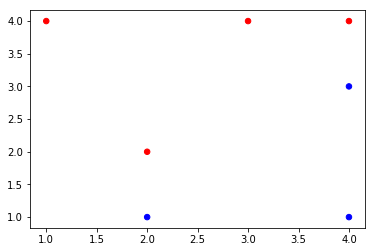

In [21]:
import pandas as pd
data = {"X1":[3,2,4,1,2,4,4],
        "X2":[4,2,4,4,1,3,1],
        "Y":["Red","Red","Red","Red","Blue","Blue","Blue"],
        "index":[1,2,3,4,5,6,7]}
df_islr = pd.DataFrame.from_dict(data)
df_islr = df_islr.set_index("index")
# model
X = df_islr.iloc[:,:-1]
y = df_islr.iloc[:,-1]
plt.scatter(X["X1"], X["X2"], c = y, s = 30, cmap = plt.cm.Paired)

<font color=black size=5 face=雅黑>(b)hyperplane</font>

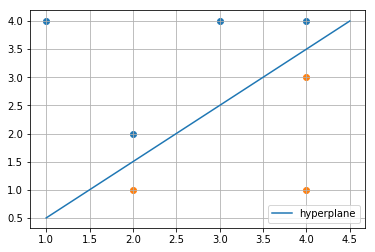

In [22]:
import numpy as np
import matplotlib.pyplot as plt
X = np.array([[3,4],[2,2],[4,4],[1,4],[2,1],[4,3],[4,1]])
y = np.array([1,1,1,1,0,0,0])
plt.scatter(X[y == 1, 0], X[y == 1, 1])
plt.scatter(X[y == 0, 0], X[y == 0, 1])
hyperplane_x = np.linspace(1, 4.5, 100)
plt.plot(hyperplane_x,hyperplane_x-0.5,label='hyperplane')
plt.grid(True)
plt.legend()

<font color=black size=4 face=雅黑>Answer: y=x−0.5  or x1-x2-0.5=0  </font>

<font color=black size=5 face=雅黑>(c)Answer: -0.5+x1+x2>0 is blue ; -0.5+x1+x2<=0 is red</font>

<font color=black size=5 face=雅黑>(d)maximal margin hyperplane</font>

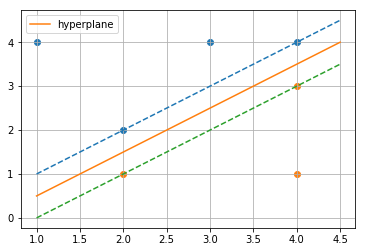

In [23]:
plt.scatter(X[y == 1, 0], X[y == 1, 1])
plt.scatter(X[y == 0, 0], X[y == 0, 1])
plt.plot(hyperplane_x, hyperplane_x,  linestyle='--');
plt.plot(hyperplane_x, hyperplane_x - 0.5,  label='hyperplane');
plt.plot(hyperplane_x, hyperplane_x - 1, linestyle='--');
plt.grid(True)
plt.legend()

<font color=black size=5 face=雅黑>(e)maximal margin hyperplane</font>

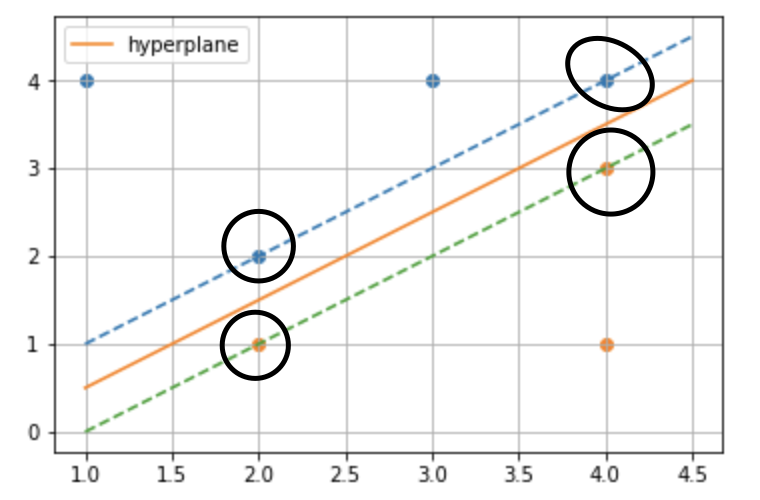

<font color=black size=5 face=雅黑>(f)if we move a bit on the bule and yellow, the hyperplane is still on the same position</font>

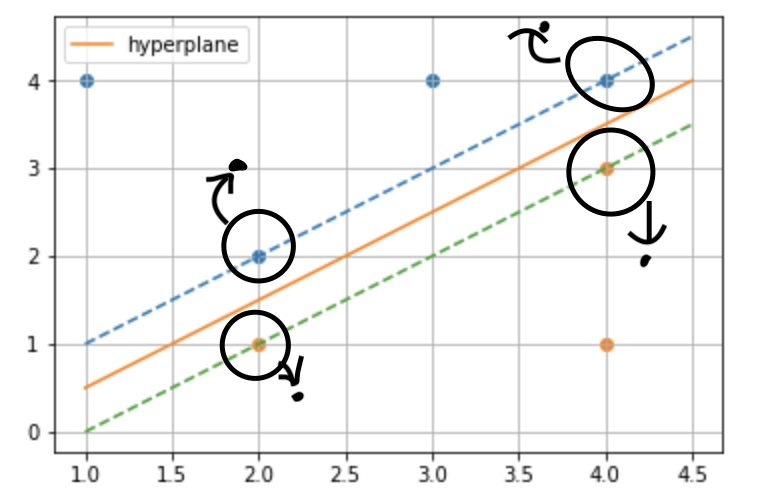

<font color=black size=5 face=雅黑>(g)not the optimal separating hyperplane</font>

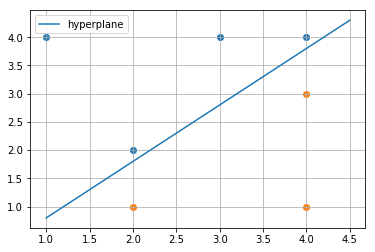

In [24]:
plt.scatter(X[y == 1, 0], X[y == 1, 1] )
plt.scatter(X[y == 0, 0], X[y == 0, 1] )
plt.plot(hyperplane_x, hyperplane_x - 0.2,label='hyperplane');
plt.grid(True)
plt.legend()

<font color=black size=5 face=雅黑>(h)additional observation on the plot so that the two classes are no longer separable by a hyperplane</font>

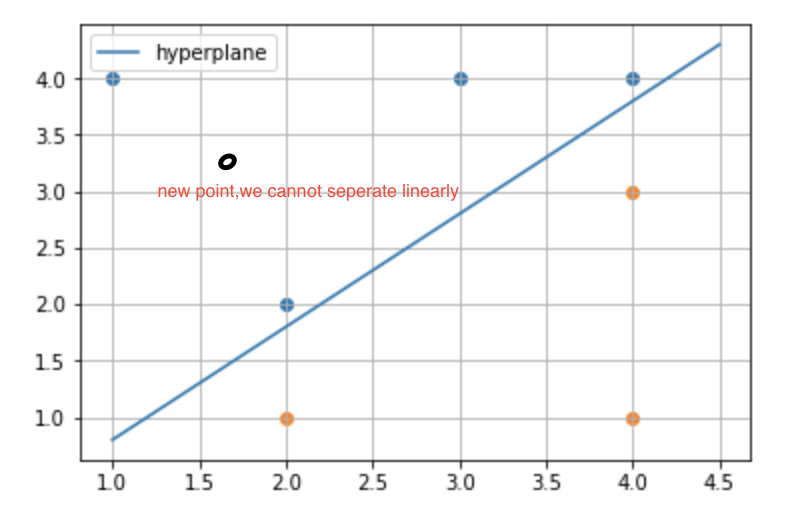